# Loading Libraries

In [1]:
# Pandas, Numpy
import pandas as pd
import numpy as np 

# Tensorflow
import tensorflow as tf 

# RBM from Recommenders
from recommenders.models.rbm.rbm import RBM 
from recommenders.utils.timer import Timer 
from recommenders.utils.plot import line_graph 

# Affinity Matrix 
from recommenders.datasets.sparse import AffinityMatrix

# Evaluation 
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k
)
from sklearn.metrics import accuracy_score 

# Visualization
from matplotlib import pyplot as plt 

# Import & Read Dataset

In [2]:
# Read Train & Test Data
train = pd.read_csv("../../00_Data/online_retail_train.csv", index_col=0)
test = pd.read_csv("../../00_Data/online_retail_test.csv", index_col=0)

In [3]:
# Check Shapes
print("Shape of Train:", train.shape)
print("Shape of Test: \t", test.shape)

Shape of Train: (206861, 3)
Shape of Test: 	 (51879, 3)


In [8]:
# Check Number of Unique Items and User in Train & Test 
print("Unique Users in Train:", train.CustomerID.nunique())
print("Unique Users in Test:", test.CustomerID.nunique())
print("Unique Items in Train:", train.StockCode.nunique())
print("Unique Items in Test:", test.StockCode.nunique())

Unique Users in Train: 3690
Unique Users in Test: 3690
Unique Items in Train: 2746
Unique Items in Test: 2746


# Preparation of Datasets for Modeling 

In [9]:
# Set standard names for the analysis 
header = {
        "col_user": "CustomerID",
        "col_item": "StockCode",
        "col_rating": "purchased",
    }

# Instantiate the sparse matrix generation  
am_train = AffinityMatrix(df = train, col_user='CustomerID', col_item='StockCode', col_rating='purchased')
am_test = AffinityMatrix(df = test, col_user='CustomerID', col_item='StockCode', col_rating='purchased')

# Obtain the sparse matrix 
Xtr, _, _ = am_train.gen_affinity_matrix()
Xtst, _, _ = am_test.gen_affinity_matrix()

In [10]:
# Sanity Check: Print Shape of Train & Test Matrix - Do numbers match nr of unique users and items from above 
print(Xtr.shape)
print(Xtst.shape) 

(3690, 2746)
(3690, 2746)


In [11]:
# Sanity Check 2: Do the sum of values match number of instances in train and test set?
print(np.sum(Xtr))
print(np.sum(Xtst))

206861
51879


In [35]:
# Change Values above 0 to 5 for Top N training
Xtst = np.where(Xtst > 0, 5, Xtst)
Xtr = np.where(Xtr > 0, 5, Xtr)

In [36]:
# Sanity check: Xtr & Xtst After reloading & Transformation
print(np.unique(Xtr))
print(np.unique(Xtst))

[0 5]
[0 5]


# Modeling

## Hyperparameter Tuning 1 

In [37]:
# Set up Parameters 
hidden_neurons = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
batch = [100, 200, 300]
lrate = [0.001, 0.002, 0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  500 neurons: 0.38258434241114875
Recall at 10 for  500 neurons: 0.4069743586597455
Recall at 10 for  500 neurons: 0.3847560924964059
Recall at 10 for  500 neurons: 0.3457080638818893
Recall at 10 for  500 neurons: 0.332482842065759
Recall at 10 for  500 neurons: 0.36037108906774445
Recall at 10 for  500 neurons: 0.3823524204545404
Recall at 10 for  500 neurons: 0.3964259563903627
Recall at 10 for  500 neurons: 0.31718477448689386
Recall at 10 for  500 neurons: 0.3354199144949133
Recall at 10 for  500 neurons: 0.3498281020459493
Recall at 10 for  500 neurons: 0.360270833338197
Recall at 10 for  600 neurons: 0.4482003302282155
Recall at 10 for  600 neurons: 0.3683513618086593
Recall at 10 for  600 neurons: 0.2826919103165146
Recall at 10 for  600 neurons: 0.22851645786604058
Recall at 10 for  600 neurons: 0.42886683048533286
Recall at 10 for  600 neurons: 0.4496521637592231
Recall at 10 for  600 neurons: 0.4511346744891122
Recall at 10 for  600 neurons: 0.44007535263108

In [38]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_1 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_1.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
23,600,300,0.004,0.453017,0.588878,0.362737,0.251070
18,600,200,0.003,0.451135,0.609023,0.364472,0.259783
17,600,200,0.002,0.449652,0.586092,0.359892,0.250068
12,600,100,0.001,0.448200,0.610523,0.363360,0.261016
22,600,300,0.003,0.440264,0.574895,0.352276,0.244160
...,...,...,...,...,...,...,...
111,1400,100,0.004,0.058651,0.106345,0.074688,0.068184
75,1100,100,0.004,0.058107,0.100597,0.070515,0.061599
98,1300,100,0.003,0.051270,0.094302,0.063415,0.058469
123,1500,100,0.004,0.048152,0.093243,0.064282,0.062520


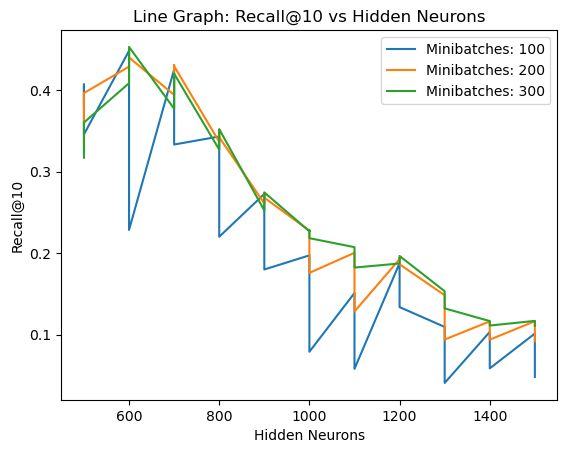

In [39]:
# Group the DataFrame by unique values in "minibatches"
grouped_df = df_tuning_1.groupby('minibatches')

# Create a line for each unique value in "minibatches"
for minibatch_value, group in grouped_df:
    # Extract the relevant data for the current "minibatches" value
    x_values = group['hidden_neurons']
    y_values = group['recall@10']

    # Plot the line
    plt.plot(x_values, y_values, label=f'Minibatches: {minibatch_value}')

# Customize the graph
plt.title('Line Graph: Recall@10 vs Hidden Neurons')
plt.xlabel('Hidden Neurons')
plt.ylabel('Recall@10')
plt.legend()

# Display the graph
plt.show()

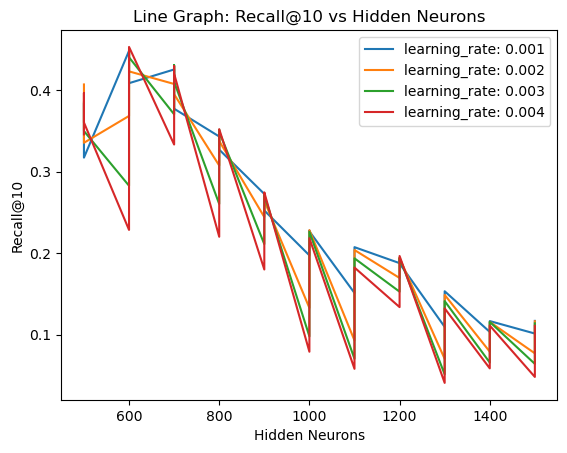

In [40]:
# Group the DataFrame by unique values in "minibatches"
grouped_df = df_tuning_1.groupby('learning_rates')

# Create a line for each unique value in "minibatches"
for learning_rate_value, group in grouped_df:
    # Extract the relevant data for the current "minibatches" value
    x_values = group['hidden_neurons']
    y_values = group['recall@10']

    # Plot the line
    plt.plot(x_values, y_values, label=f'learning_rate: {learning_rate_value}')

# Customize the graph
plt.title('Line Graph: Recall@10 vs Hidden Neurons')
plt.xlabel('Hidden Neurons')
plt.ylabel('Recall@10')
plt.legend()

# Display the graph
plt.show()

## Hyperparameter Tuning 2

In [41]:
# Set up Parameters 
hidden_neurons = [550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650]
batch = [100, 200, 300]
lrate = [0.001, 0.002, 0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  550 neurons: 0.40714438191343433
Recall at 10 for  550 neurons: 0.3873472575738843
Recall at 10 for  550 neurons: 0.32064394503808
Recall at 10 for  550 neurons: 0.26712678049090277
Recall at 10 for  550 neurons: 0.364091985092001
Recall at 10 for  550 neurons: 0.3890635692628696
Recall at 10 for  550 neurons: 0.4070599017352322
Recall at 10 for  550 neurons: 0.4138012745071601
Recall at 10 for  550 neurons: 0.3423677676314801
Recall at 10 for  550 neurons: 0.367008007360659
Recall at 10 for  550 neurons: 0.3811611783772501
Recall at 10 for  550 neurons: 0.3887238113793481
Recall at 10 for  560 neurons: 0.4323202601051769
Recall at 10 for  560 neurons: 0.44993989815429364
Recall at 10 for  560 neurons: 0.4256628395400781
Recall at 10 for  560 neurons: 0.3864427061447546
Recall at 10 for  560 neurons: 0.38590279194457716
Recall at 10 for  560 neurons: 0.4103608177882196
Recall at 10 for  560 neurons: 0.4273627387334428
Recall at 10 for  560 neurons: 0.4470213815290418


In [42]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_2 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_2.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
71,600,300,0.004,0.454743,0.591370,0.362846,0.252209
65,600,200,0.002,0.451036,0.590414,0.362466,0.251450
66,600,200,0.003,0.450163,0.607949,0.366179,0.260894
13,560,100,0.002,0.449940,0.585208,0.357480,0.246260
19,560,200,0.004,0.447021,0.564043,0.347859,0.235434
...,...,...,...,...,...,...,...
74,610,100,0.003,0.144527,0.285387,0.143144,0.141978
110,640,100,0.003,0.124746,0.252544,0.126748,0.128103
123,650,100,0.004,0.121613,0.256609,0.126938,0.131599
75,610,100,0.004,0.105394,0.213792,0.107561,0.108469


# Final Tuning Round

In [48]:
# Set up Parameters 
hidden_neurons = [591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609]
batch = [200, 300]
lrate = [0.003, 0.004]

# Initiate Lists for Assessment
recall_10 = []
recall_20 = []
precision_10 = []
precision_20 = []
neurons = []
batches = []
learning_rates = []

# Loop through lists of parameters 

for n in hidden_neurons:
    for b in batch:
        for l in lrate:
            # Delete Model First
            try:
                del(model)
            except:
                pass
            
            # Define Model with Parameters
            model = RBM(
                possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=n,
                training_epoch=30,
                minibatch_size=b,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=l,
                seed=42
            )
            
            # Fit Model 
            model.fit(Xtr)
            
            # Recommend top k
            top_k = model.recommend_k_items(Xtst, top_k=20, remove_seen=True)
            
            # Map Back Xtst & Top K
            top_k_df = am_test.map_back_sparse(top_k, kind = 'prediction')
            test_df  = am_test.map_back_sparse(Xtst, kind='ratings')
            
            # Evaluation 
            recall_at_ten  = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=10)
            recall_at_twenty = recall_at_k(test_df, top_k_df, col_user="CustomerID", col_item="StockCode", 
                                    col_rating="purchased", col_prediction="prediction", 
                                    relevancy_method="top_k", k=20)
            precision_at_ten = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                            col_rating ='purchased', col_prediction="prediction",
                                            relevancy_method='top_k', k = 10)
            precision_at_twenty = precision_at_k(test_df, top_k_df, col_user='CustomerID', col_item='StockCode',
                                col_rating ='purchased', col_prediction="prediction",
                                relevancy_method='top_k', k = 20)
            
            # Append lists 
            recall_10.append(recall_at_ten)
            recall_20.append(recall_at_twenty)
            precision_10.append(precision_at_ten)
            precision_20.append(precision_at_twenty)
            neurons.append(n)
            batches.append(b)
            learning_rates.append(l)
            
            # Print Results 
            print("Recall at 10 for ", n, "neurons:", recall_at_ten)

Recall at 10 for  591 neurons: 0.4828887778203033
Recall at 10 for  591 neurons: 0.4929515095723823
Recall at 10 for  591 neurons: 0.45563959375429
Recall at 10 for  591 neurons: 0.4690520857807881
Recall at 10 for  592 neurons: 0.4476923511267779
Recall at 10 for  592 neurons: 0.43504644950692395
Recall at 10 for  592 neurons: 0.4365136116171642
Recall at 10 for  592 neurons: 0.4452234930255502
Recall at 10 for  593 neurons: 0.4348905448387627
Recall at 10 for  593 neurons: 0.41743746827423106
Recall at 10 for  593 neurons: 0.42747271530502046
Recall at 10 for  593 neurons: 0.4369842099994526
Recall at 10 for  594 neurons: 0.4596396188856156
Recall at 10 for  594 neurons: 0.4647451467160105
Recall at 10 for  594 neurons: 0.4319338918087914
Recall at 10 for  594 neurons: 0.4474727544982177
Recall at 10 for  595 neurons: 0.4366456907040285
Recall at 10 for  595 neurons: 0.430530193367354
Recall at 10 for  595 neurons: 0.42688182329724056
Recall at 10 for  595 neurons: 0.4366308624227125

In [49]:
# Create Dataframe out of the Results of the Hyperparameter Tuning 
df_tuning_3 = pd.DataFrame({
    "hidden_neurons": neurons,
    "minibatches": batches,
    "learning_rates":learning_rates,
    "recall@10": recall_10,
    "recall@20": recall_20,
    "precision@10":precision_10,
    "precision@20":precision_20
})
# Sort Values by recall@10 
df_tuning_3.sort_values(by='recall@10', ascending=False)

,hidden_neurons,minibatches,learning_rates,recall@10,recall@20,precision@10,precision@20
1,591,200,0.004,0.492952,0.620800,0.388916,0.264255
0,591,200,0.003,0.482889,0.608737,0.381599,0.259160
3,591,300,0.004,0.469052,0.588276,0.369919,0.249201
13,594,200,0.004,0.464745,0.614573,0.376450,0.263130
29,598,200,0.004,0.462230,0.602889,0.368808,0.255976
...,...,...,...,...,...,...,...
71,608,300,0.004,0.395446,0.554543,0.326396,0.237087
68,608,200,0.003,0.393609,0.569375,0.330298,0.244201
33,599,200,0.004,0.392763,0.604798,0.330650,0.259661
69,608,200,0.004,0.388483,0.580183,0.327209,0.249621


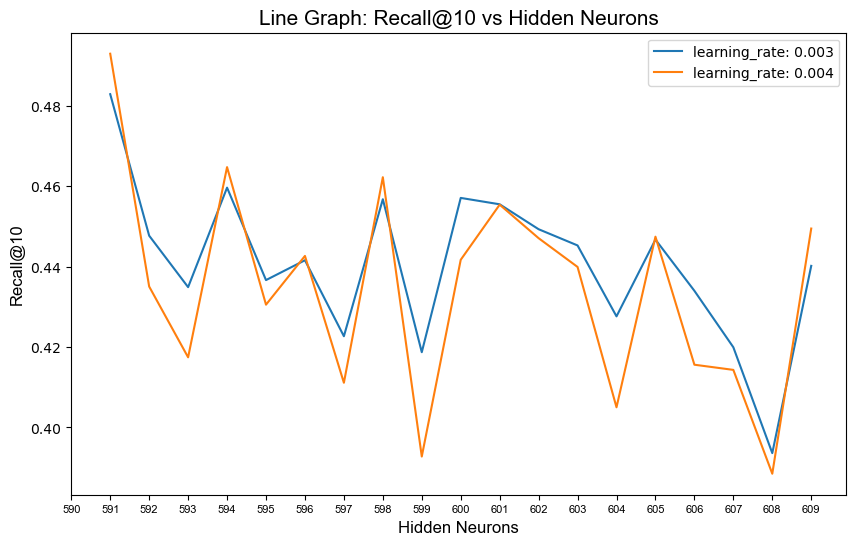

In [94]:
# Filter out minibathces 200 
df_tuning_3_mb200 = df_tuning_3[df_tuning_3['minibatches']==200]
# Group the DataFrame by unique values in "minibatches"
grouped_df = df_tuning_3_mb200.groupby('learning_rates')

# Set Figsize:
plt.figure(figsize=(10,6))
# Create a line for each unique value in "minibatches"
for learning_rate_value, group in grouped_df:
    # Extract the relevant data for the current "minibatches" value
    x_values = group['hidden_neurons']
    y_values = group['recall@10']

    # Plot the line
    plt.plot(x_values, y_values, label=f'learning_rate: {learning_rate_value}')

# Customize the graph
plt.title('Line Graph: Recall@10 vs Hidden Neurons',fontname='Arial', fontsize=15)
plt.xlabel('Hidden Neurons',fontname='Arial', fontsize=12)
plt.xticks(np.arange(590,610, step=1),fontname='Arial', fontsize=8)
plt.ylabel('Recall@10',fontname='Arial', fontsize=12)
plt.legend()

# Display the graph
plt.show()

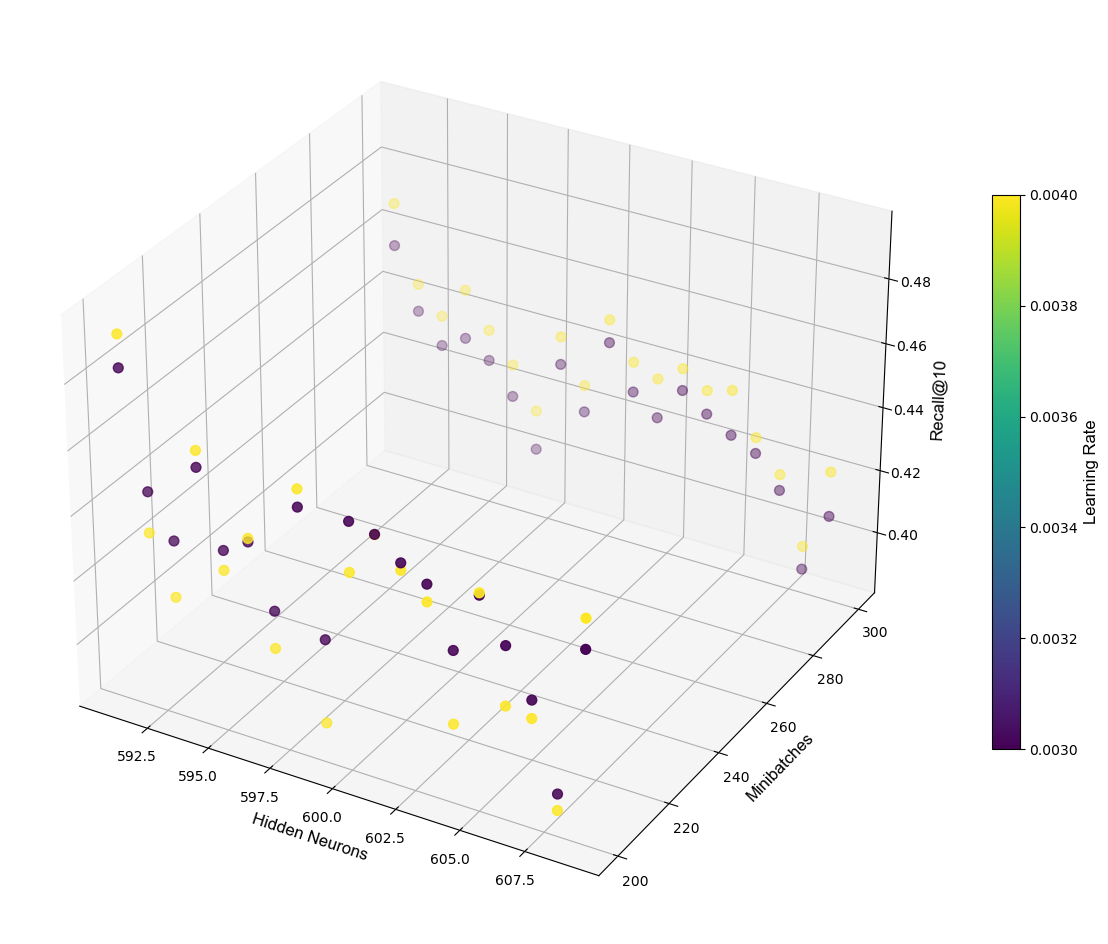

In [123]:
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(projection='3d')

x, y, z = df_tuning_3.hidden_neurons, df_tuning_3['minibatches'], df_tuning_3['recall@10']
ax.set_xlabel('Hidden Neurons', fontname='Arial', fontsize=12)
ax.set_ylabel('Minibatches',fontname='Arial', fontsize=12)
ax.set_zlabel('Recall@10',fontname='Arial', fontsize=12)
scatter = ax.scatter(x,y,z, cmap='viridis', marker='o', s=50, c=df_tuning_3['learning_rates'])

# Colorbar
cbar = plt.colorbar(scatter, shrink=0.6)
cbar.set_label('Learning Rate', fontname='Arial', fontsize=12)
plt.show()


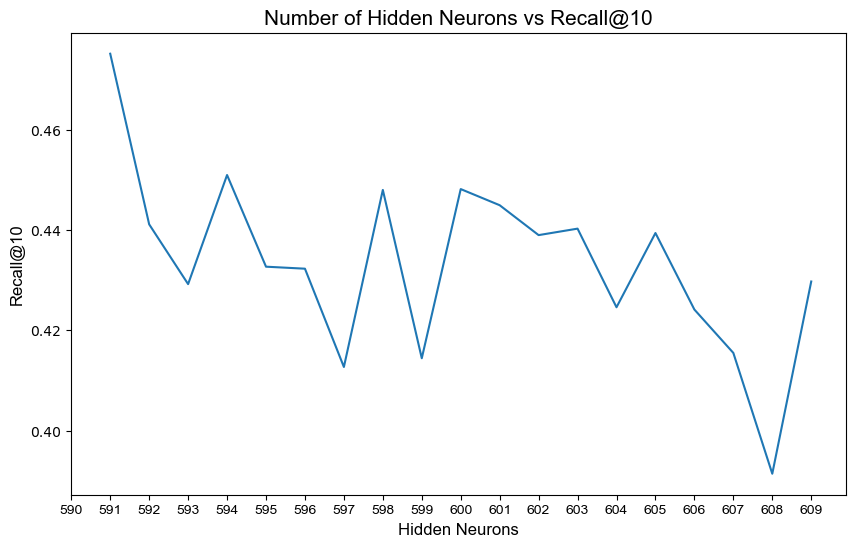

In [114]:
# Neurons averaged
avg_perf_neurons = df_tuning_3.groupby('hidden_neurons')['recall@10'].mean()

# Plot
plt.figure(figsize=(10,6))
plt.plot(avg_perf_neurons.index, avg_perf_neurons.values)
plt.title('Number of Hidden Neurons vs Recall@10',fontname='Arial', fontsize=15)
plt.xlabel('Hidden Neurons',fontname='Arial', fontsize=12)
plt.xticks(np.arange(590,610, step=1),fontname='Arial', fontsize=10)
plt.ylabel('Recall@10',fontname='Arial', fontsize=12)


plt.show()

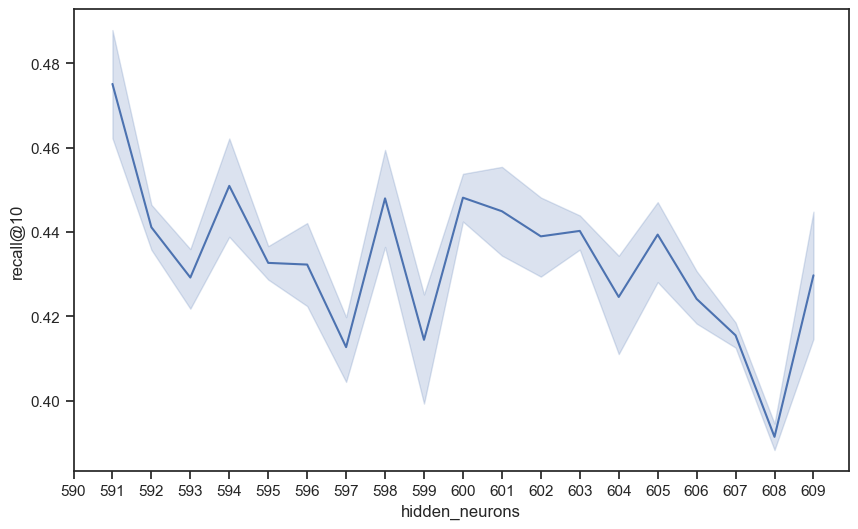

In [132]:
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("ticks")
ax = sns.lineplot(data=df_tuning_3, x='hidden_neurons', y='recall@10')
ax.set_xticks(np.arange(590,610, step=1))

# Best Model: Accuracy on Test

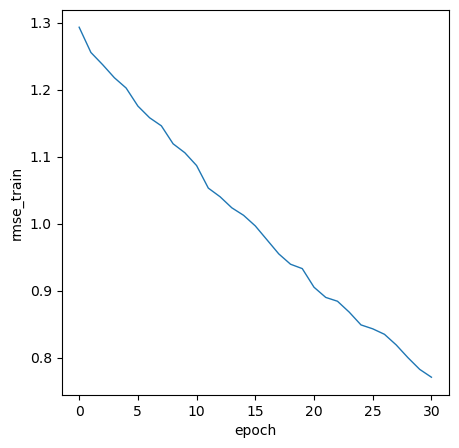

In [65]:
# Set up Model Object
best_model = RBM(possible_ratings=[1., 5.], # Always provide this range - way better results! 
                visible_units=Xtr.shape[1],
                hidden_units=591,
                training_epoch=30,
                minibatch_size=200,
                keep_prob=0.7,
                with_metrics=True,
                learning_rate=0.004,
                seed=42)
            
# Fit Model 
best_model.fit(Xtr)

# Line Graph
line_graph(values=best_model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [68]:
# Make Predictions for entire Test Matrix
pred_test = best_model.predict(Xtst) ## Always Use Xtst for prediction - better results 

# Map Back Pred Test
pred_test = am_test.map_back_sparse(pred_test, kind = 'prediction')

# Merge test_pred with test
test_prediction_am = test_df.merge(pred_test, on=['StockCode', 'CustomerID'], how='left')

# Accuracy 
accuracy_score(test_prediction_am.purchased, test_prediction_am.prediction)

0.977216214653328